# Building a classification model by creating a labeled dataset from tweets to distinguish btwn road closures and non-road closures. 
## Goal: determine if a live tweet from MN is announcing a road closure by running it through this model

Using 13k scraped tweets from blue-check verified Dept of Transportation Twitter accounts in Minnesota, we will create a labeled data set with `Y` target values: 
  - `1`: Road Closure
  - `0`: Not Road Closure

The labeled dataset will contained balanced classes -- an even distribution of road closure and non-road closure announcements. 

Tweets will be identified as road closures based on an analysis of road closure announcements made on official Dept of Transportation websites. For this case study, we use [MN 511 Road Closure Announcements](https://lb.511mn.org//mnlb/roadreports/menu.jsf?view=state&text=m&textOnly=true&current=true) to help us determine how to filter Tweets that announce road closures. 

The goal of creating a labeled dataset is to build a model that can be used on live Tweets. 

- [**Import Libraries**](#Import-Libraries)
- [**Bar Plot Function**](#Bar-Plot-Function)
- [**Exploratory Data Analysis: MN511**](#Exploratory-Data-Analysis:-MN511)
  - [Import MN 511 Data](#Import-MN-511-Data)
  - [CountVectorizer n_gram = 1,1 on MN511](#CountVectorizer-n_gram-=-1,1-on-MN511)
  - [CountVectorizer n_gram = 2,2 on MN511](#CountVectorizer-n_gram-=-2,2-on-MN511)
- [EDA: North Dakota 511](#EDA:-North-Dakota-511)
  - [Import ND 511 data](#Import-ND-511-data)
  - [Drop rows containing variations of the words "open" and "lifted"](#Drop-rows-containing-variations-of-the-words-"open"-and-"lifted")
  - [CountVectorizer n_gram = 1,1 on ND511](#CountVectorizer-n_gram-=-1,1-on-ND511)
  - [CountVectorizer n_gram = 2,2 on ND511](#CountVectorizer-n_gram-=-1,1-on-ND511)
- [Import Twitter Data](#Import-Twitter-Data)
  - [Split df_mntwitter into tweets announcing road closures, and not announcing road closures](#Split-df_mntwitter-into-tweets-announcing-road-closures,-and-not-announcing-road-closures.)
  - [Non-Road Closure DataFrame: df_mn_open](#Non-Road-Closure-DataFrame:-df_mn_open)
- [Pre-Processing](#Pre-Processing)
  - [Baseline Score](#Baseline-Score)
  - [Set X (predictor) and y (target) variables](#Set X-(predictor)-and-y-(target)-variables)
  - [Train/Test Split](#Train/Test-Split)
- [Modeling](#Modeling)
  - [CountVectorizer & Logistic Regression (Best Coefficient Interpretability)](#CountVectorizer-&-Logistic-Regression-(Best-Coefficient-Interpretability))
  - [Run the model](#Run-the-model)
  - [Confusion Matrix](#Confusion-Matrix)
  - [Coefficient Analysis](#Coefficient-Analysis)
- [Run the model on unseen data](#Run-the-model-on-unseen-data)

# Import Libraries

In [3]:
# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Natural Language Processing
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

### Bar Plot Function

In [35]:
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(8,4))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

# Exploratory Data Analysis: MN511

### Import MN 511 Data

In [36]:
df = pd.read_csv('../data/alldata_update.csv')

In [37]:
df.head()

,Unnamed: 0,date,text,keywords,location,source
0,0,2019-04-12 12:40:24+00:00,Crash at Hwy 12/25 south of Buffalo. Traffic i...,NaN,NaN,twitter
1,1,2019-04-12 00:05:20+00:00,"WB I-94, west of Sauk Centre- closed due to du...",NaN,NaN,twitter
2,2,2019-04-11 22:30:44+00:00,No travel advised on Hwy 169 along the west si...,NaN,NaN,twitter
3,3,2019-04-11 22:17:09+00:00,No Travel Advised has been expanded to include...,#Stearns #centralMN,NaN,twitter
4,4,2019-04-11 19:49:47+00:00,No Travel Advisory issued for I-94 through @St...,NaN,NaN,twitter


In [38]:
# Create a new dataframe showing only MN511 announcements
df_mn511 = df[df['source'] == 'mn511']
df_mn511.reset_index(drop=True, inplace=True)
df_mn511.head()

,Unnamed: 0,date,text,keywords,location,source
0,0,date,Between MN 93; North 5th Street and US 169 (ne...,MN 19: Flooding.,"[('North 5th Street', 'GPE'), ('Henderson', 'G...",mn511
1,1,date,Between US 169 (Le Sueur) and MN 19; North 5th...,MN 93: Flooding.,"[('US', 'GPE')]",mn511
2,2,date,At Fern Street North (Cambridge). The road is ...,MN 95: Road closed.,[],mn511
3,3,date,Between 220th Avenue and 230th Avenue (Halstad...,US 75 in both directions: Flooding.,[],mn511
4,4,date,Between North Dakota State Line (Oslo) and 470...,MN 1: Flooding.,"[('North Dakota', 'GPE'), ('Oslo', 'GPE'), ('A...",mn511


### CountVectorizer n_gram = 1,1 on MN511
  - Find most frequently used unigrams (single words)

In [39]:
# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec = cv.fit_transform(df_mn511['text'])

# Convert cvec into a DataFrame
mn511_cvec = pd.DataFrame(cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect new DF
print(mn511_cvec.shape)

(14, 74)


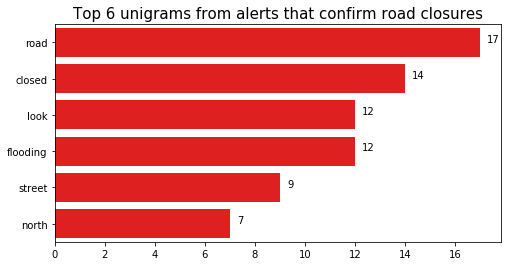

In [40]:
# Set up variables to contain top 5 most used words 
mn511_cvec_wc1 = mn511_cvec.sum(axis = 0).sort_values(ascending=False).head(6)

# Call bar plot function
bar_plot(mn511_cvec_wc1.values, mn511_cvec_wc1.index, 'Top 6 unigrams from alerts that confirm road closures','r')


  - Of the 14 road closure announcements made on 511, all of them include the words "road" and "closed"

### CountVectorizer n_gram = 2,2 on MN511
  - Find most frequently used bigrams (word pairs)

In [41]:
# Instantiate a CountVectorizer
cv2 = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
cvec2 = cv2.fit_transform(df_mn511['text'])

# Convert cvec into a DataFrame
mn511_cvec2 = pd.DataFrame(cvec2.toarray(),
                   columns=cv2.get_feature_names())

# Inspect new DF
print(mn511_cvec2.shape)

(14, 114)


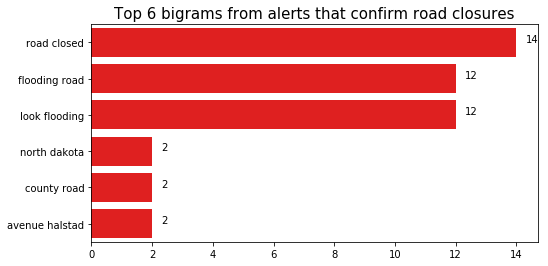

In [42]:
# Set up variables to contain top 5 most used words
mn511_cvec_wc2 = mn511_cvec2.sum(axis = 0).sort_values(ascending=False).head(6)

# Call bar plot function
bar_plot(mn511_cvec_wc2.values, mn511_cvec_wc2.index, 'Top 6 bigrams from alerts that confirm road closures','r')

  - Of the 14 road closure announcements made on 511, all of them include the phrase "road closed"

# EDA: North Dakota 511

### Import ND 511 data

In [43]:
# Read in csv with ND511 announcements
df_nd511 = pd.read_csv('../data/nd_511.csv')

# Drop columns so that only tweets are shown
df_nd511.drop(columns=['Unnamed: 0',
                             'alert_type',
                             'url',
                             'post'], inplace=True)
# Change column name
df_nd511.rename(columns={'headline':'text'}, inplace=True)

# Print DF shape
print(df_nd511.shape)

# Show head 
df_nd511.head()

(134, 1)


,text
0,"Water receded on I-29, 20 miles north of Grand..."
1,ND Hwy 5 temporarily closed from I-29 to the R...
2,Water on I-29 north of Grand Forks
3,Water on I-29 north of Grand Forks
4,Southbound on ramp on I-29 Exit 164 north of G...


### Drop rows containing variations of the words "open" and "lifted"
  - Announcements on ND 511 containing the words "open" and "lifted" announce the opening of road closures. So we want to get rid of those here. 

In [44]:
to_drop = ["OPEN", "OPENED", "open", "opened", "lifed", "LIFTED"]

df_nd511 = df_nd511[~df_nd511['text'].str.contains('|'.join(to_drop))]

### CountVectorizer n_gram = 1,1 on ND511
  - Find most frequently used unigrams (single words)

In [45]:
# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec = cv.fit_transform(df_nd511['text'])

# Convert cvec into a DataFrame
nd511_cvec = pd.DataFrame(cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect new DF
print(nd511_cvec.shape)

(110, 139)


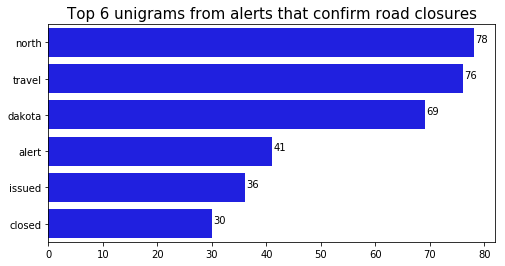

In [46]:
# Set up variables to contain top 5 most used words 
nd511_cvec_wc1 = nd511_cvec.sum(axis = 0).sort_values(ascending=False).head(6)

# Call bar plot function
bar_plot(nd511_cvec_wc1.values, nd511_cvec_wc1.index, 'Top 6 unigrams from alerts that confirm road closures','b')

  - Of the 110 official road closure announcements on ND511, not all announcements contain a common word. 

### CountVectorizer n_gram = 2,2 on ND511
  - Find most frequently used bigrams (word pairs)

In [47]:
# Instantiate a CountVectorizer
cv2 = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
cvec2 = cv2.fit_transform(df_nd511['text'])

# Convert cvec into a DataFrame
nd511_cvec2 = pd.DataFrame(cvec2.toarray(),
                   columns=cv2.get_feature_names())

# Inspect new DF
print(nd511_cvec2.shape)

(110, 259)


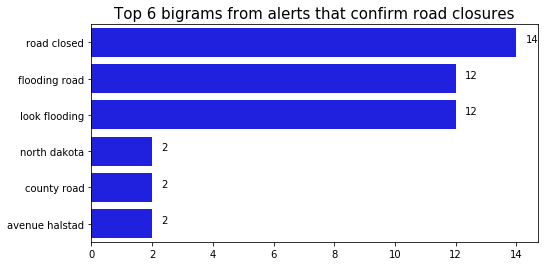

In [48]:
# Set up variables to contain top 5 most used words
nd511_cvec_wc2 = mn511_cvec2.sum(axis = 0).sort_values(ascending=False).head(6)

# Call bar plot function
bar_plot(nd511_cvec_wc2.values, nd511_cvec_wc2.index, 'Top 6 bigrams from alerts that confirm road closures','b')

  - Only 14 of 110 road closure announcements use the phrase "road closed" to announce a road closure. 

# Import Twitter data

In [124]:
# Import data and save to variable 
df_mntwitter = pd.read_csv('../data/alldata_update.csv')

# Drop column
df_mntwitter.drop(['Unnamed: 0', 'keywords', 'location', 'date'], axis=1, inplace=True)

# Filter data to show only tweets
df_mntwitter[df['source'] == 'twitter']

df_mntwitter['source'] = 'mn_twitter'

# Inspect data
print(f'Shape: {df_mntwitter.shape}')
df_mntwitter.head()

Shape: (14233, 2)


,text,source
0,Crash at Hwy 12/25 south of Buffalo. Traffic i...,mn_twitter
1,"WB I-94, west of Sauk Centre- closed due to du...",mn_twitter
2,No travel advised on Hwy 169 along the west si...,mn_twitter
3,No Travel Advised has been expanded to include...,mn_twitter
4,No Travel Advisory issued for I-94 through @St...,mn_twitter


In [125]:
# drop all rows with nulls
df_mntwitter.dropna(inplace=True)

print(f'Shape: {df_mntwitter.shape}')

Shape: (14232, 2)


### Split `df_mntwitter` into tweets announcing road closures, and not announcing road closures. 
  - Using EDA from MN511, create a filter to separate road closure tweets from non-road closure tweets

### Road Closure DataFrame: `df_mn_closures`

In [126]:
# Drop any rows that announce a reversal of a road closure
df_mn_closures = df_mntwitter[~df_mntwitter.text.str.contains("open")]
df_mn_closures = df_mn_closures[~df_mn_closures.text.str.contains("lift")]

In [127]:
# Since the words "road" and "closed" appeared in all MN511 posts, filter for those words here. 
mask_road = df_mn_closures['text'].str.contains('road closed', regex=False, case=False)
mask_road1 = df_mn_closures['text'].str.contains('remains closed', regex=False, case=False)
mask_closed = df_mn_closures['text'].str.contains('closed', regex=False, case=False)
mask_closed1 = df_mn_closures['text'].str.contains('no travel', regex=False, case=False)

df_mn_closures = df_mn_closures[mask_road1 | mask_road | mask_closed | mask_closed1]

In [128]:
# Set target variable 
df_mn_closures['road_closure'] = 1
df_mn_closures.head()

,text,source,road_closure
1,"WB I-94, west of Sauk Centre- closed due to du...",mn_twitter,1
2,No travel advised on Hwy 169 along the west si...,mn_twitter,1
3,No Travel Advised has been expanded to include...,mn_twitter,1
4,No Travel Advisory issued for I-94 through @St...,mn_twitter,1
6,I-94 Clearwater to St. Cloud - both directions...,mn_twitter,1


In [129]:
# Dataset with all True Positives: all road closures! 
df_mn_closures.shape

(1133, 3)

In [130]:
# Drop rows with False Positives (where road closure was not the case)
df_mn_closures.drop([4524, 4435, 4423, 4418], inplace=True)

### Non-Road Closure DataFrame: `df_mn_open`

In [131]:
# Get index number of tweets identified as road closures 
closed = list(df_mn_closures.index)

# Remove all road closure tweets from this dataframe
df_mn_open = df_mntwitter.drop(closed)

# Drop any instances where false positives might occur
df_mn_open = df_mn_open[~df_mn_open.text.str.contains("remains closed")]
df_mn_open = df_mn_open[~df_mn_open.text.str.contains("remains close")]

# Shape
df_mn_open.shape

(13077, 2)

In [132]:
# To maintain balanced classes, I will drop rows in `df_mn_open` so that they are equal to `df_mn_closures`

df_mn_open = df_mn_open.iloc[0:1133]
df_mn_open.shape

(1133, 2)

In [133]:
# Set target variable 
df_mn_open['road_closure'] = 0
df_mn_open.head()

,text,source,road_closure
0,Crash at Hwy 12/25 south of Buffalo. Traffic i...,mn_twitter,0
5,I-94 Clearwater to St. Cloud - all lanes are n...,mn_twitter,0
7,Eastbound I-94 Monticello to Albertville - all...,mn_twitter,0
10,How cool are snow fences that reduce crashes? ...,mn_twitter,0
11,Belgrade - we want your opinion tonight! Join ...,mn_twitter,0


# Pre-Processing

In [134]:
# Merge dataframes
df_mn_training = pd.concat([df_mn_open, df_mn_closures], axis=0)
df_mn_training.shape

(2262, 3)

### Baseline Score

In [135]:
# Baseline score
df_mn_training['road_closure'].value_counts(normalize=True)

0    0.500884
1    0.499116
Name: road_closure, dtype: float64

I expect my model to be better than 5%. The majority class is 1, or, road closures. If the model is not better than 50%, I know the model is not performing well.

### Set `X` (predictor) and `y` (target) variables

In [136]:
X = df_mn_training['text']
y = df_mn_training['road_closure']

### Train/Test Split

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

# Modeling

### CountVectorizer & Logistic Regression (Best Coefficient Interpretability)

In [138]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english'],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.9899764150943396
Train score 1.0
Test score 0.9929328621908127


{'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__C': 1}

### Run the model 

In [157]:
#Instantiate the classifier and vectorizer
lr = LogisticRegression(C = 1.0, solver='liblinear')
cvec = CountVectorizer()

# Fit and transform the vectorizor
cvec.fit(X_train)

Xcvec_train = cvec.transform(X_train)
Xcvec_test = cvec.transform(X_test)

# Fit the classifier
lr.fit(Xcvec_train,y_train)

# Create the predictions for Y training data
lr_preds = lr.predict(Xcvec_test)

print(f'Train Score: {lr.score(Xcvec_train, y_train)}')
print(f'Test Score: {lr.score(Xcvec_test, y_test)}')

Test Score: 1.0
Test Score: 0.9929328621908127


In [140]:
Xcvec_train

<1696x4890 sparse matrix of type '<class 'numpy.int64'>'
	with 45581 stored elements in Compressed Sparse Row format>

### Confusion Matrix

In [141]:
# Create a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, lr_preds)
cnf_matrix

array([[280,   4],
       [  0, 282]])

Text(0.5, 257.44, 'Predicted label')

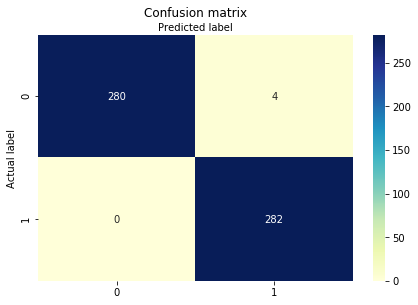

In [142]:
# Code from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

# name  of classes
class_names=[0,1] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [143]:
# Assign True Neg, False Pos, False Neg, True Pos variables
cnf_matrix = np.array(cnf_matrix).tolist()

tn_fp, fn_tp = cnf_matrix

tn, fp = tn_fp
fn, tp = fn_tp

In [144]:
# Print Scores 

print("Accuracy:",round(metrics.accuracy_score(y_test, lr_preds)*100, 2),'%')
print("Precision:",round(metrics.precision_score(y_test, lr_preds)*100, 2), '%')
print("Recall:",round(metrics.recall_score(y_test, lr_preds)*100, 2), '%')
print("Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')

Accuracy: 99.29 %
Precision: 98.6 %
Recall: 100.0 %
Specificity: 98.59 %
Misclassification Rate: 0.71 %


### Coefficient Analysis

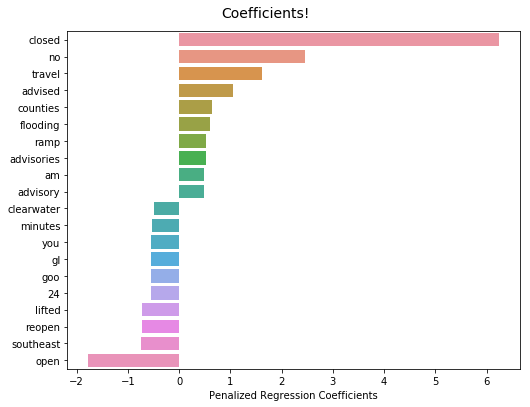

In [145]:
# Create list of logistic regression coefficients 
lr_coef = np.array(lr.coef_).tolist()
lr_coef = lr_coef[0]

# create dataframe from lasso coef
lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
cvec.get_feature_names(), columns = ["penalized_regression_coefficients"])

# sort the values from high to low
lr_coef = lr_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)

# Create top and bottom 10 
df_head = lr_coef.head(10)
df_tail = lr_coef.tail(10)

# merge back together
df_merged = pd.concat([df_head, df_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.suptitle('Coefficients!', size=14)
ax = sns.barplot(x = 'penalized_regression_coefficients', y= df_merged.index, 
data=df_merged)
ax.set(xlabel='Penalized Regression Coefficients')
plt.tight_layout(pad=3, w_pad=0, h_pad=0);

In [146]:
print("The word that contributes the most positively to being a tweet announcing a road closure is", 
      "'",df_merged.index[0],"'", "followed by", 
      "'",df_merged.index[1],"'", "and",
      "'",df_merged.index[2],"'",".")

print("-----------------------------------")

print("The word that contributes the most positively to being a tweet announcing a NON-road closure is", 
      "'",df_merged.index[-1],"'", "followed by", 
      "'",df_merged.index[-2],"'", "and",
      "'",df_merged.index[-3],"'",".")

The word that contributes the most positively to being a tweet announcing a road closure is ' closed ' followed by ' no ' and ' travel ' .
-----------------------------------
The word that contributes the most positively to being a tweet announcing a NON-road closure is ' open ' followed by ' southeast ' and ' reopen ' .


In [147]:
# Show coefficients that affect tweets announcing road closures
df_merged_head = df_merged.head(10)
exp = df_merged_head['penalized_regression_coefficients'].apply(lambda x: np.exp(x))
df_merged_head.insert(1, 'exp', exp)
df_merged_head.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
closed,6.244,514.914053
no,2.450,11.588347
travel,1.624,5.073343
advised,1.044,2.840557
counties,0.652,1.919376
flooding,0.607,1.834918
ramp,0.525,1.690459
advisories,0.516,1.675313
am,0.484,1.622552
advisory,0.483,1.620930


In [148]:
print("As occurences of", "'",df_merged_head.index[0],"'", "increase by 1 in a tweet, that tweet is", 
      round(df_merged_head['exp'][0],2), "times as likely to be classified as a road closure.")

As occurences of ' closed ' increase by 1 in a tweet, that tweet is 514.91 times as likely to be classified as a road closure.


In [149]:
# Show coefficients that affect tweets announcing non-road closures
df_merged_tail = df_merged.tail(10)
exp = df_merged_tail['penalized_regression_coefficients'].apply(lambda x: np.exp(x * -1))
df_merged_tail.insert(1, 'exp', exp)
df_merged_tail.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
open,-1.779,5.923930
southeast,-0.736,2.087569
reopen,-0.717,2.048279
lifted,-0.714,2.042144
24,-0.554,1.740200
gl,-0.547,1.728061
goo,-0.547,1.728061
you,-0.543,1.721163
minutes,-0.526,1.692150
clearwater,-0.488,1.629055


In [150]:
print("As occurences of", "'",df_merged_tail.index[-1],"'", "increase by 1 in a tweet, that tweet is", 
      round(df_merged_tail['exp'][-1],2), "times as likely to be classified as a NON road closure.")

As occurences of ' open ' increase by 1 in a tweet, that tweet is 5.92 times as likely to be classified as a NON road closure.


# Run the model on unseen data

In [151]:
# load unseen tweets
df_mn_unseen_tweets = pd.read_csv('../data/twitter_mn_official_UNSEEN.csv')

# Drop columns
df_mn_unseen_tweets.drop(['Unnamed: 0', 'date', 'geo', 'hashtags', 'type', 'username'], axis=1, inplace=True)

# print shape
print(df_mn_unseen_tweets.shape)

# show head
df_mn_unseen_tweets.head()

(126, 1)


,text
0,Congrats to our ‘Safe Routes to School’ grant ...
1,@MnDOTcentral thanks all our 'Adopt a Highway ...
2,Hwy 55 roadwork and DETOUR between Annandale a...
3,Hwy 27 Little Falls: DETOUR and construction b...
4,Join us in BRAHAM: Construction Open House for...


In [ ]:
#Instantiate the classifier and vectorizer
lr = LogisticRegression(C = 1.0, solver='liblinear')
cvec = CountVectorizer()

# Fit and transform the vectorizor
cvec.fit(X_train)

Xcvec_train = cvec.transform(X_train)
Xcvec_test = cvec.transform(X_test)

# Fit the classifier
lr.fit(Xcvec_train,y_train)

# Create the predictions for Y training data
lr_preds = lr.predict(Xcvec_test)

print(f'Test Score: {lr.score(Xcvec_train, y_train)}')
print(f'Test Score: {lr.score(Xcvec_test, y_test)}')

In [158]:
#Instantiate the classifier and vectorizer
lr = LogisticRegression(C = 1.0, solver='liblinear')
cvec = CountVectorizer()

# Fit and transform the vectorizor
cvec.fit(X_train)

Xcvec_train = cvec.transform(X_train)
Xcvec_test = cvec.transform(df_mn_unseen_tweets['text'])

# Fit the classifier
lr.fit(Xcvec_train,y_train)

# Create the predictions for Y training data
lr_preds = lr.predict(Xcvec_test)

# print(f'Test Score: {lr.score(Xcvec_train, y_train)}')
# print(f'Test Score: {lr.score(Xcvec_test, y_test)}')

In [161]:
df_mn_unseen_tweets['road_closures'] = lr_preds

In [163]:
for i in range(len(df_mn_unseen_tweets)):
    print("PREDICTION",df_mn_unseen_tweets['road_closures'].loc[i])
    print(df_mn_unseen_tweets['text'].loc[i])
    print("------------------------------------------")

PREDICTION 0
Congrats to our ‘Safe Routes to School’ grant recipients @MnDOTCentral: Rockford Area Schools; City of Pierz; City of Holdingford; City of Sauk Centre; and Walker-Hackensack-Akeley School District.https://twitter.com/MnDOTnews/status/1120392155967762432 …
------------------------------------------
PREDICTION 0
@MnDOTcentral thanks all our 'Adopt a Highway volunteers' for making our roadside ditches look so clean and beautiful in central Minnesota.THANK YOU!https://twitter.com/MnDOTnews/status/1120392060576641025 …
------------------------------------------
PREDICTION 0
Hwy 55 roadwork and DETOUR between Annandale and Maple Lake, @WrightCountyMN begins Monday, April 29. Plan ahead. Learn more, visit http://MnDOT.gov/d3/projects/2019/h55/ … pic.twitter.com/JjZCGKdTUA
------------------------------------------
PREDICTION 0
Hwy 27 Little Falls: DETOUR and construction begins Monday, April 29. Plan ahead. #littlefallsMN #morrison Learn more, visit http://www.mndot.gov/d3/little